## Import Libraries

In [ ]:
import nltk
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import load_model

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
SEED_VALUE = 24

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## Load dataset

In [ ]:
df = pd.read_csv("/content/spam.csv", encoding= 'latin1')
print("Sample Data")
print("============")
print(df.head(10))

Sample Data
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   
5  spam  FreeMsg Hey there darling it's been 3 week's n...        NaN   
6   ham  Even my brother is not like to speak with me. ...        NaN   
7   ham  As per your request 'Melle Melle (Oru Minnamin...        NaN   
8  spam  WINNER!! As a valued network customer you have...        NaN   
9  spam  Had your mobile 11 months or more? U R entitle...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
5        NaN        NaN  
6 

In [ ]:
#dropping unnecessary columns

df = df[['v1', 'v2']]

In [ ]:
print(df.head())

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
df = df.rename(columns={
    'v1' : 'label',
    'v2' : 'text'
})

In [ ]:
# Understand Sample Data

print("\n\nAttributes in Sample Data:")
print("==========================\n")

print(df.columns)



Attributes in Sample Data:

Index(['label', 'text'], dtype='object')


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [ ]:
print(df.describe())

       label                    text
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30


In [ ]:
print(df["label"].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


## Dataset Preprocessing




### Function 1: Removing Stopwords

In [ ]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  words = text.split()
  filtered_sentence = ''
  for word in words:
    if word not in stop_words:
      filtered_sentence = filtered_sentence + word + ' '
  return filtered_sentence

### Function 2: Handling Special Characters

In [ ]:
def normalize_text(text):
  text = text.lower()
  # Remove HTML tags (if applicable)
  text = re.sub(r"<[^>]*>", "", text)
  # get rid of urls
  text = re.sub('https?://\S+|www\.\S+', '', text)
  # get rid of non words and extra spaces
  text = re.sub('\\W', ' ', text)
  text = re.sub('\n', '', text)
  text = re.sub(' +', ' ', text)
  text = re.sub('^ ', '', text)
  text = re.sub(' $', '', text)
  return text

### Function 3: Remove Punctuations

In [ ]:
def remove_punctuation(text):
  table = str.maketrans('','',string.punctuation)
  words = text.split()
  filtered_sentence = ''
  for word in words:
    word = word.translate(table)
    filtered_sentence = filtered_sentence + word + ' '
  return filtered_sentence

## Function 4: Remove Emojis ✈✌

In [ ]:
def remove_emoji(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

## Function 5: Lemmatization

In [ ]:
def stemming(text):
  ps = PorterStemmer()
  words = text.split()
  filtered_sentence = ''
  for word in words:
    word = ps.stem(word)
    filtered_sentence = filtered_sentence + word + ' '
  return filtered_sentence

These functions will serve as the foundation for preparing our text data, ensuring that we’re working with clean and standardized text before moving forward with the sentiment analysis.

Let’s call all functions in one.

In [ ]:
def clean_text(text):
  text = text.lower()
  text = text.replace(',',' , ')
  text = text.replace('.',' . ')
  text = text.replace('/',' / ')
  text = text.replace('@',' @ ')
  text = text.replace('#',' # ')
  text = text.replace('?',' ? ')
  text = normalize_text(text)
  text = remove_punctuation(text)
  text = remove_stopwords(text)
  text = stemming(text)
  return text

In [ ]:
clean_df = df.copy()
clean_df['text'] = clean_df['text'].apply(clean_text)
print("cleaned dataset")
print("=================")
print(clean_df.head(10))

cleaned dataset
  label                                               text
0   ham  go jurong point crazi avail bugi n great world...
1   ham                             ok lar joke wif u oni 
2  spam  free entri 2 wkli comp win fa cup final tkt 21...
3   ham               u dun say earli hor u c alreadi say 
4   ham              nah think goe usf live around though 
5  spam  freemsg hey darl 3 week word back like fun sti...
6   ham     even brother like speak treat like aid patent 
7   ham  per request mell mell oru minnaminungint nurun...
8  spam  winner valu network custom select receivea å 9...
9  spam  mobil 11 month u r entitl updat latest colour ...


In [ ]:
# Label Encoding the output
encoding_map = {
    'ham' : 0,
    'spam' : 1,
}
encoder = LabelEncoder()
encoder.fit(list(encoding_map.keys()))
clean_df["label"] = encoder.transform(clean_df["label"])
print("Encoded dataset")
print("================")
print(clean_df.head(10))

Encoded dataset
   label                                               text
0      0  go jurong point crazi avail bugi n great world...
1      0                             ok lar joke wif u oni 
2      1  free entri 2 wkli comp win fa cup final tkt 21...
3      0               u dun say earli hor u c alreadi say 
4      0              nah think goe usf live around though 
5      1  freemsg hey darl 3 week word back like fun sti...
6      0     even brother like speak treat like aid patent 
7      0  per request mell mell oru minnaminungint nurun...
8      1  winner valu network custom select receivea å 9...
9      1  mobil 11 month u r entitl updat latest colour ...


In [ ]:
X = clean_df["text"]
Y = clean_df["label"]
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size = 0.2, random_state = SEED_VALUE, shuffle = True)

## Tokenization and Padding
**Tokenization:** Splitting text into meaningful units, such as words or characters, for analysis.

**Padding:** Ensuring consistent input length for machine learning models by adding placeholders to shorter sequences.

First Let’s define some properties

In [ ]:
# Tokenization
vocab_size = 10000
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

1. **vocab_size = 10000:** This sets the maximum number of unique words in our vocabulary. Only the top 10,000 most frequently occurring words will be considered.

2. **trunc_type = 'post':** When a text is longer than the specified max_length, the truncation type determines where the truncation occurs. In this case, 'post' means that it will truncate at the end of the text.
3. **padding_type = 'post':** Padding is applied to texts that are shorter than max_length. 'post' means that padding will be added at the end of the text.
4. **oov_tok :** This represents the Out-Of-Vocabulary token. It’s a placeholder for words that are not in the vocabulary, allowing the model to handle unseen words during training.

These properties are crucial for preparing text data before feeding it into a neural network for processing or analysis.

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)  # Create tokenizer with 5000 most frequent words
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

1. **Tokenizer Definition:** We create a tokenizer, a tool that converts text into a numerical format suitable for neural networks.

2. **num_words=vocab_size** limits the tokenizer to consider only the top 10,000 most frequent words, based on the vocab_size defined earlier.

3. oov_token=oov_tok assigns the special token <OOV> to out-of-vocabulary words, which are words not in the tokenizer's vocabulary.

Fitting on Texts: We ‘fit’ the tokenizer on the text data (x_train). This process analyzes the text, builds the vocabulary, and assigns numerical values to the words.

This prepares the tokenizer to convert text data into a format that can be processed by a neural network.



In [ ]:
# Padding sequences
#max_length = max(len(x) for x in X)
max_length = 150

print("Maximum word length = ",max_length)
X_train = pad_sequences(x_train, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)
X_test = pad_sequences(x_test, maxlen=max_length,
                       padding=padding_type,
                       truncating=trunc_type)

Maximum word length =  150


**max_length :** This determines the maximum length of a sequence. If a text has more than 50 words, it will be truncated. If it has fewer, it will be padded to reach this length.

In [ ]:
print("x train shape: ", x_train)
print("x test shape: ", x_test)

x train shape:  [[1044, 331, 1685, 332, 2147], [256, 551, 6, 117, 672, 2148, 40, 45, 581, 516, 1208, 256, 71, 14, 239], [132, 332, 372, 104, 2, 2, 10, 3171, 3172, 552, 3173, 1686, 3174, 1687, 232, 143], [137, 226, 94, 2, 347, 94], [13, 250, 517, 348, 2, 1688], [333, 17, 62, 17], [13, 317], [90, 553, 284, 233], [48, 69, 1209, 554, 9, 8, 3175], [132, 40, 77, 165, 10, 360, 425, 518, 81, 3, 3176, 466, 191, 388, 519], [304, 49, 24], [166, 95, 50, 100, 56, 24, 71], [3177, 845, 2149, 2], [11, 582, 92, 1425, 6, 520, 53, 142], [625, 21, 18, 1426, 144, 583, 45, 126, 200, 120, 1045, 208, 138, 45, 3178, 1426, 82, 82, 625, 673, 3179, 1046, 138, 45, 9, 8, 361, 930, 3180, 3181, 36, 6, 34], [83, 108, 521, 177, 21, 5, 448, 146, 285, 196, 3182, 1047], [63, 11], [48, 48, 19, 449, 70], [18, 9, 8, 160, 147], [177, 48, 128], [3183, 7, 1427, 2150, 3184], [201, 42, 51, 139, 845, 69, 318, 21, 274, 2151, 160, 484, 1689, 1689, 92, 1048, 3185], [1049, 21, 31, 4, 86, 846, 25, 1428, 584, 1050, 50, 1428, 584], [23, 

In [ ]:
# Embedding layer
embedding_dim = 128  # Embedding dimension
embedding_layer = Embedding(input_dim=tokenizer.num_words, output_dim=embedding_dim, input_length=max_length)

In [ ]:
# Model definition
model = Sequential([
  Embedding(input_dim = vocab_size, output_dim = 64, input_length=max_length),
  # Single Simple RNN layer with 32 units
  SimpleRNN(32, input_shape = (vocab_size, max_length), return_sequences=False, activation = 'relu'),
  #Dropout(0.2),
  Dense(1, activation="sigmoid")  # Output layer with sigmoid activation for binary classification
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 64)           640000    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model compilation
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
print(x_train)

[[1044, 331, 1685, 332, 2147], [256, 551, 6, 117, 672, 2148, 40, 45, 581, 516, 1208, 256, 71, 14, 239], [132, 332, 372, 104, 2, 2, 10, 3171, 3172, 552, 3173, 1686, 3174, 1687, 232, 143], [137, 226, 94, 2, 347, 94], [13, 250, 517, 348, 2, 1688], [333, 17, 62, 17], [13, 317], [90, 553, 284, 233], [48, 69, 1209, 554, 9, 8, 3175], [132, 40, 77, 165, 10, 360, 425, 518, 81, 3, 3176, 466, 191, 388, 519], [304, 49, 24], [166, 95, 50, 100, 56, 24, 71], [3177, 845, 2149, 2], [11, 582, 92, 1425, 6, 520, 53, 142], [625, 21, 18, 1426, 144, 583, 45, 126, 200, 120, 1045, 208, 138, 45, 3178, 1426, 82, 82, 625, 673, 3179, 1046, 138, 45, 9, 8, 361, 930, 3180, 3181, 36, 6, 34], [83, 108, 521, 177, 21, 5, 448, 146, 285, 196, 3182, 1047], [63, 11], [48, 48, 19, 449, 70], [18, 9, 8, 160, 147], [177, 48, 128], [3183, 7, 1427, 2150, 3184], [201, 42, 51, 139, 845, 69, 318, 21, 274, 2151, 160, 484, 1689, 1689, 92, 1048, 3185], [1049, 21, 31, 4, 86, 846, 25, 1428, 584, 1050, 50, 1428, 584], [23, 6, 3, 50, 217], 

In [ ]:
# Train the model
history = model.fit(X_train, y_train, batch_size = 32, epochs=10,
                    validation_split=0.1, shuffle = True, verbose = 1)

Epoch 1/10
126/126 [==============================] - 10s 65ms/step - loss: 0.4680 - accuracy: 0.8504 - val_loss: 0.3277 - val_accuracy: 0.8991
Epoch 2/10
126/126 [==============================] - 5s 38ms/step - loss: 0.4065 - accuracy: 0.8609 - val_loss: 0.3320 - val_accuracy: 0.8991
Epoch 3/10
126/126 [==============================] - 6s 47ms/step - loss: 0.4047 - accuracy: 0.8609 - val_loss: 0.3284 - val_accuracy: 0.8991
Epoch 4/10
126/126 [==============================] - 6s 48ms/step - loss: 0.4052 - accuracy: 0.8609 - val_loss: 0.3320 - val_accuracy: 0.8991
Epoch 5/10
126/126 [==============================] - 5s 38ms/step - loss: 0.4045 - accuracy: 0.8609 - val_loss: 0.3518 - val_accuracy: 0.8991
Epoch 6/10
126/126 [==============================] - 8s 65ms/step - loss: 0.4053 - accuracy: 0.8609 - val_loss: 0.3304 - val_accuracy: 0.8991
Epoch 7/10
126/126 [==============================] - 5s 38ms/step - loss: 0.4043 - accuracy: 0.8609 - val_loss: 0.3399 - val_accuracy: 0.899

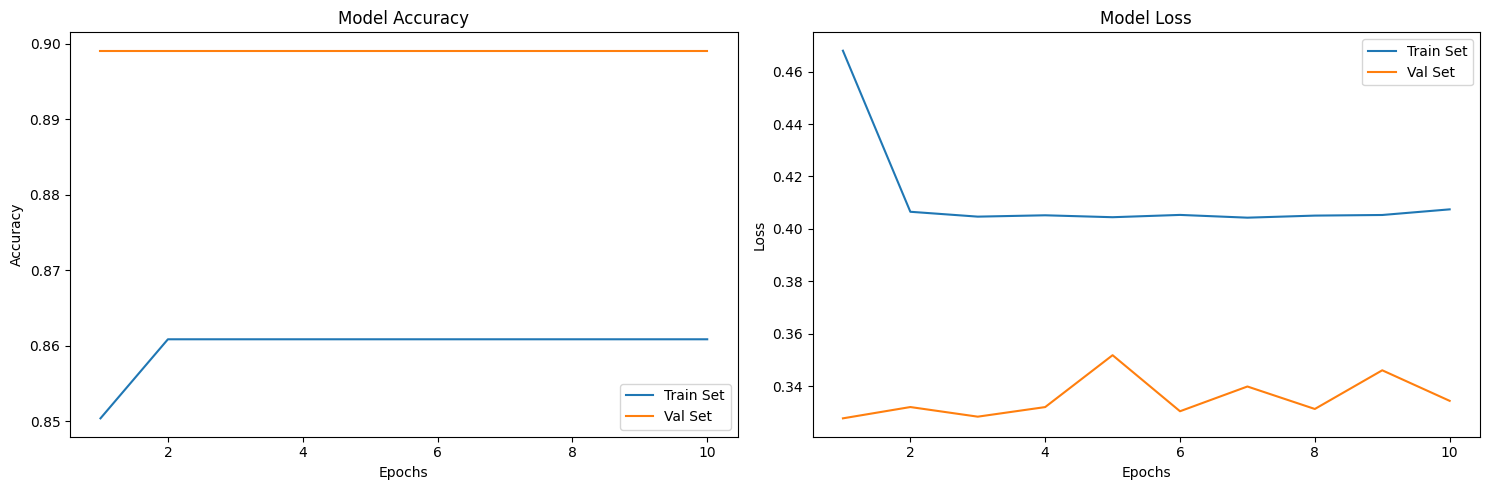

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation
loss, accuracy = model.evaluate(X_test,y_test)
print("Test Accuracy: ",np.round(acc,2))

35/35 [==============================] - 0s 9ms/step - loss: 0.3854 - accuracy: 0.8709
Test Accuracy:  [0.85 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86]


In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int")
y_pred = predictions.flatten()
print(y_pred)

35/35 [==============================] - 1s 13ms/step
[0 0 0 ... 0 0 0]


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

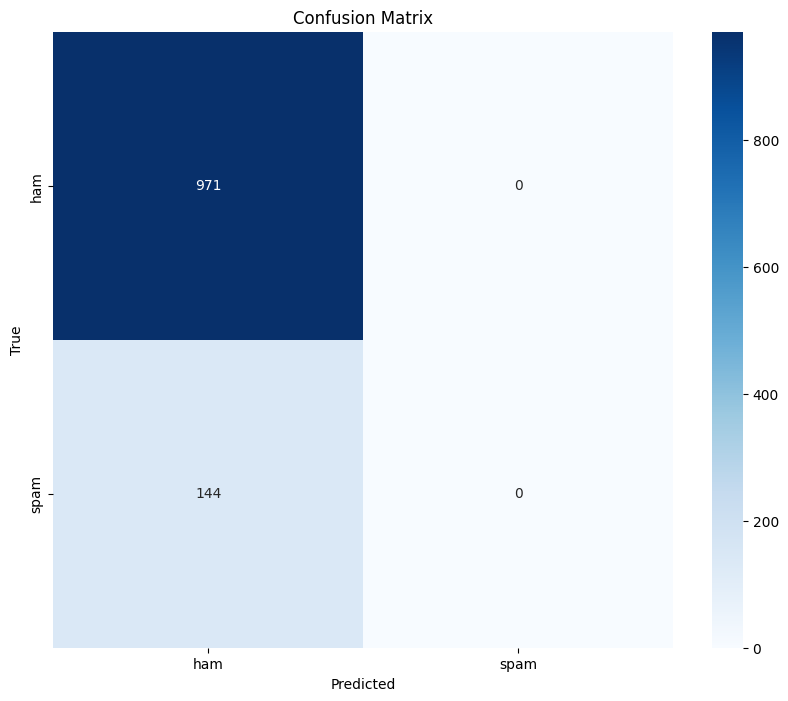

In [ ]:
# Plot confusion matrix
labels = ['ham','spam']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#print classification report and confusion matrix
print(classification_report(y_test,y_pred,target_names = labels,digits = 4))

              precision    recall  f1-score   support

         ham     0.8709    1.0000    0.9310       971
        spam     0.0000    0.0000    0.0000       144

    accuracy                         0.8709      1115
   macro avg     0.4354    0.5000    0.4655      1115
weighted avg     0.7584    0.8709    0.8107      1115



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save("/content/drive/MyDrive/dl11_model/model_rnn.keras")

## Application Phase

In [ ]:
model = load_model("/content/drive/MyDrive/dl11_model/model_rnn.keras")

In [ ]:
# User input prediction
user_text = input("Enter text: ")
user_sequence = tokenizer.texts_to_sequences([user_text])
user_padded_sequence = pad_sequences(user_sequence, maxlen=max_length)
pred = (model.predict(user_padded_sequence) > 0.5).astype("int")

if (pred == 0):
  print("Not Spam")
else:
  print("Spam")

Enter text: I am Kendrick Lamar. I urgently need 2000 to back to California. 
1/1 [==============================] - 0s 22ms/step
Not Spam
